In [2]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from scipy.interpolate import Rbf

np.random.seed(7)

Using TensorFlow backend.


In [3]:
from slim21 import LSTMs
import os.path

pth = '/home/wolveszhao/zhaozhuo/CSE885Final'
os.chdir(pth)

[1, 1, 2, 2, 5, 5, 5, 5, 5, 7, 8, 8, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 15, 15, 15, 51, 51, 57, 58, 60, 68, 74, 98, 118, 149, 217, 262, 402, 518, 583, 959, 1281, 1663, 2179, 2727, 3499, 4632, 6421, 7783, 13747, 19273, 25600, 33276, 43843, 53736, 65778, 83836, 101657, 121465, 140909, 161831, 188172, 213372, 243762, 275586, 308853, 337072, 366667, 397505, 429052, 462780, 496535, 526396, 555313, 580619, 607670, 636350, 667592, 699706, 732197, 759086, 784326, 823786]


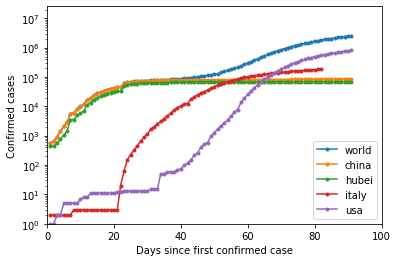

In [31]:
df = pd.read_csv(pth + '/Data/time_series_covid19_confirmed_global.csv')
countries=df[df.columns[1]] # country names 
columns=df.columns #labels 

def get_country_total(country):
    all_pop = []
    for col in country.columns[4:]:
        all_pop.append(country[col].sum())
    return all_pop

def get_cum_data(x):
    for i,item in enumerate(x):
        nonzero = i
        if item != 0: break
    return x[nonzero:]
 
    
world = get_country_total(df)    
china = df[countries=='China']
hubei= get_country_total(china[china[china.columns[0]]=='Hubei'])
china = get_country_total(china)
#print(china)
usa = get_country_total(df[countries=='US'])
print(usa)
italy = get_country_total(df[countries=='Italy'])
#print(italy)

world_cum = get_cum_data(world)
china_cum = get_cum_data(china)
hubei_cum = get_cum_data(hubei)
usa_cum = get_cum_data(usa)
italy_cum = get_cum_data(italy)

days_cum_world = np.arange(1,len(world_cum)+1,1)
days_cum_china = np.arange(1,len(china_cum)+1,1)
days_cum_hubei = np.arange(1,len(hubei_cum)+1,1)
days_cum_italy = np.arange(1,len(italy_cum)+1,1)
days_cum_usa = np.arange(1,len(usa_cum)+1,1)

fig, ax1 = plt.subplots()
ax1.plot(days_cum_world,world_cum,'.-',label='world')
ax1.plot(days_cum_china,china_cum,'.-',label='china')
ax1.plot(days_cum_hubei,hubei_cum,'.-',label='hubei')
ax1.plot(days_cum_italy,italy_cum,'.-',label='italy')
ax1.plot(days_cum_usa,usa_cum,'.-',label='usa')
ax1.set_xlim(0,max(days_cum_china)*1.1)
ax1.set_ylim(1,max(world_cum)*10)
plt.yscale('log')
#plt.xscale('log')
ax1.legend()
ax1.set_xlabel('Days since first confirmed case')
ax1.set_ylabel('Confirmed cases')
#ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

fig.savefig("confirmed_world_log.pdf", bbox_inches='tight')
plt.show()


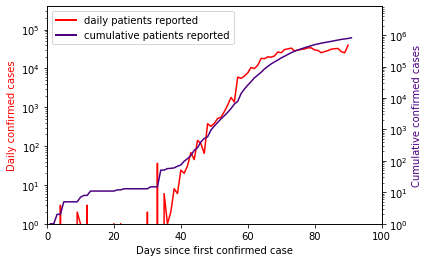

In [32]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def get_deltas(x):
    you=x[0]
    deltas = []
    for me in x[1:]:
        deltas.append(me-you)
        you=me
    return deltas
    
deltas_usa=get_deltas(usa_cum)
days_delta_usa = np.arange(1,len(deltas_usa)+1,1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(days_delta_usa, deltas_usa, color='r', linestyle='-')
ax2.plot(days_cum_usa, usa_cum, color='indigo', linestyle='-')

ax1.set_xlabel('Days since first confirmed case')
ax1.set_ylabel('Daily confirmed cases', color='r')
ax2.set_ylabel('Cumulative confirmed cases', color='indigo')
ax1.set_xlim(0,max(days_cum_usa)*1.1)
ax1.set_ylim(1,max(deltas_usa)*10)
ax2.set_ylim(1,max(usa_cum)*10)
ax1.set_yscale('log')
ax2.set_yscale('log')

legend_elements = [Line2D([0], [0], color='r', lw=2, label='daily patients reported'),
                   Line2D([0], [0], color='indigo', lw=2, label='cumulative patients reported')]
ax1.legend(handles=legend_elements, loc='upper left')

fig.savefig("confirmed_usa_log.pdf", bbox_inches='tight')
plt.show()

[1.25280901e+00 1.11652930e+06 1.16224509e+01]
fitting Score: 3988.33 RMSE
normalized fitting Score: 0.03 RMSE
232


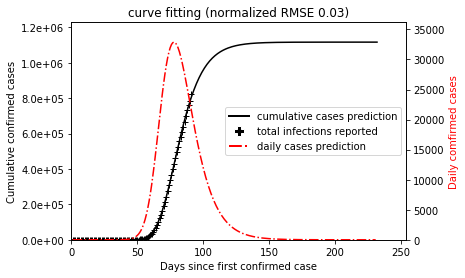

In [34]:
from scipy.optimize import curve_fit


def func(t,x0,xt,tau):
    return np.exp(np.log(xt)/(1+(np.log(xt)/np.log(x0)-1)*np.exp(-t/tau)))


popt, pcov = curve_fit(func,days_cum_usa,usa_cum, bounds=([1.001,usa_cum[-1],1e-3], [1000,usa_cum[-1]*1e3, 1e3]))
print(popt)

fitting_data = func(days_cum_usa,*popt)
# calculate root mean squared error
Score = math.sqrt(mean_squared_error(usa_cum, fitting_data))
print('fitting Score: %.2f RMSE' % (Score))
print('normalized fitting Score: %.2f RMSE' % (Score/np.mean(usa_cum)))


func_days = np.arange(1,popt[2]*20,1)
func_predict = func(func_days,*popt)
print(len(func_predict))
deltas_func = get_deltas(func_predict)
days_delta_func = np.arange(1,len(deltas_func)+1,1)

fig, ax1 = plt.subplots()
ax1.plot(func_days, func_predict, 'k-')
ax1.plot(days_cum_usa, usa_cum, 'k+')
ax2 = ax1.twinx()
ax2.plot(days_delta_func, deltas_func, 'r-.')

ax1.set_xlabel('Days since first confirmed case')
ax1.set_ylabel('Cumulative confirmed cases', color='k')
ax2.set_ylabel('Daily comfirmed cases', color='r')
ax1.set_xlim(0,max(days_delta_func)*1.1)
ax1.set_ylim(0,max(func_predict)*1.1)
ax2.set_ylim(0,max(deltas_func)*1.1)
ax1.set_title('curve fitting (normalized RMSE {0:.2f})'.format(Score/np.mean(usa_cum)))
ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

legend_elements = [Line2D([0], [0], color='k', lw=2, label='cumulative cases prediction'),
                   Line2D([0], [0], marker='P', color='w', markerfacecolor='k', markersize=10,label='total infections reported'),
                   Line2D([0], [0], color='r',linestyle='-.', lw=2, label='daily cases prediction')]

ax1.legend(handles=legend_elements, loc='center right')
fig.savefig("death_fitting_prediction.pdf", bbox_inches='tight')

plt.show()



82 9
Epoch 1/50
 - 17s - loss: 0.0240
Epoch 2/50
 - 0s - loss: 0.0204
Epoch 3/50
 - 0s - loss: 0.0185
Epoch 4/50
 - 0s - loss: 0.0170
Epoch 5/50
 - 0s - loss: 0.0153
Epoch 6/50
 - 0s - loss: 0.0136
Epoch 7/50
 - 0s - loss: 0.0120
Epoch 8/50
 - 0s - loss: 0.0102
Epoch 9/50
 - 0s - loss: 0.0083
Epoch 10/50
 - 0s - loss: 0.0067
Epoch 11/50
 - 0s - loss: 0.0052
Epoch 12/50
 - 0s - loss: 0.0039
Epoch 13/50
 - 0s - loss: 0.0028
Epoch 14/50
 - 0s - loss: 0.0019
Epoch 15/50
 - 0s - loss: 0.0012
Epoch 16/50
 - 0s - loss: 7.3908e-04
Epoch 17/50
 - 0s - loss: 4.3337e-04
Epoch 18/50
 - 0s - loss: 2.4421e-04
Epoch 19/50
 - 0s - loss: 1.3279e-04
Epoch 20/50
 - 0s - loss: 7.3780e-05
Epoch 21/50
 - 0s - loss: 4.5002e-05
Epoch 22/50
 - 0s - loss: 3.0914e-05
Epoch 23/50
 - 0s - loss: 2.5623e-05
Epoch 24/50
 - 0s - loss: 2.3385e-05
Epoch 25/50
 - 0s - loss: 2.2559e-05
Epoch 26/50
 - 0s - loss: 2.1552e-05
Epoch 27/50
 - 0s - loss: 2.0934e-05
Epoch 28/50
 - 0s - loss: 2.0845e-05
Epoch 29/50
 - 0s - loss: 2

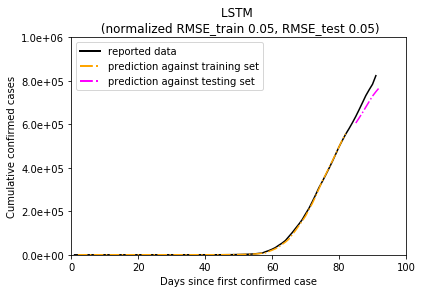

In [147]:
Data = np.array(usa_cum).reshape((len(usa_cum),1))
ld = len(Data)

def create_dataset(data, look_back=1):
    f = len(data)-look_back
    return data[:f],data[1:f+1]


scaler = MinMaxScaler(feature_range=(0, 1))
origData = np.copy(Data)
dataset = scaler.fit_transform(origData) # normalize data

train_size = int(np.round(len(dataset) * 0.90))
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:,:]
print(len(train), len(test))

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], trainPredict[:,0]))
print(len(y_train[:,0]))
print(len(trainPredict[:,0]))
print('train score: %.2f RMSE' % (trainScore))
print('normalized train score: %.2f RMSE/mean' % (trainScore/np.mean(y_train[:,0])))
testScore = math.sqrt(mean_squared_error(y_test[:,0], testPredict[:,0]))
print('test score: %.2f RMSE' % (testScore))
print('normalized test score: %.2f RMSE/mean' % (testScore/np.mean(y_test[:,0])))

# plot baseline and predictions from the correct start point
days_Data = np.arange(1, len(Data)+1,1)
days_trainPred = np.arange(2, len(trainPredict)+2,1)
days_testPred = np.arange(2, len(testPredict)+2,1)+len(trainPredict)+1+1

print(f'Data {len(Data)}, train {len(trainPredict)}, test {len(testPredict)}')

fig, ax = plt.subplots()
ax.plot(days_Data,Data, color='k')
ax.plot(days_trainPred,trainPredict, color='orange',linestyle = '-.')
ax.plot(days_testPred,testPredict, color='magenta',linestyle = '-.')

ax.set_xlabel('Days since first confirmed case')
ax.set_ylabel('Cumulative confirmed cases')
ax.set_xlim(0,100)
ax.set_ylim(0,1e6)
ax.set_title('LSTM \n (normalized RMSE_train {0:.2f}, RMSE_test {0:.2f})'.format(trainScore/np.mean(y_train[:,0]),testScore/np.mean(y_test[:,0])))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))

legend_elements = [Line2D([0], [0], color='k', lw=2, label='reported data'),
                   Line2D([0], [0], color='orange', lw=2,linestyle = '-.',label='prediction against training set'),
                   Line2D([0], [0], color='magenta', lw=2, linestyle = '-.', label='prediction against testing set')]

ax.legend(handles=legend_elements, loc='best')
fig.savefig("LSTM.pdf", bbox_inches='tight')

plt.show()

81 10
Epoch 1/50
 - 18s - loss: 0.0327
Epoch 2/50
 - 0s - loss: 0.0277
Epoch 3/50
 - 0s - loss: 0.0250
Epoch 4/50
 - 0s - loss: 0.0231
Epoch 5/50
 - 0s - loss: 0.0211
Epoch 6/50
 - 0s - loss: 0.0193
Epoch 7/50
 - 0s - loss: 0.0172
Epoch 8/50
 - 0s - loss: 0.0154
Epoch 9/50
 - 0s - loss: 0.0136
Epoch 10/50
 - 0s - loss: 0.0115
Epoch 11/50
 - 0s - loss: 0.0098
Epoch 12/50
 - 0s - loss: 0.0081
Epoch 13/50
 - 0s - loss: 0.0062
Epoch 14/50
 - 0s - loss: 0.0047
Epoch 15/50
 - 0s - loss: 0.0035
Epoch 16/50
 - 0s - loss: 0.0023
Epoch 17/50
 - 0s - loss: 0.0015
Epoch 18/50
 - 0s - loss: 9.4631e-04
Epoch 19/50
 - 0s - loss: 5.5420e-04
Epoch 20/50
 - 0s - loss: 2.8769e-04
Epoch 21/50
 - 0s - loss: 1.4235e-04
Epoch 22/50
 - 0s - loss: 7.7435e-05
Epoch 23/50
 - 0s - loss: 3.4765e-05
Epoch 24/50
 - 0s - loss: 1.9286e-05
Epoch 25/50
 - 0s - loss: 1.2260e-05
Epoch 26/50
 - 0s - loss: 9.8645e-06
Epoch 27/50
 - 0s - loss: 8.5318e-06
Epoch 28/50
 - 0s - loss: 8.4573e-06
Epoch 29/50
 - 0s - loss: 8.5319e-

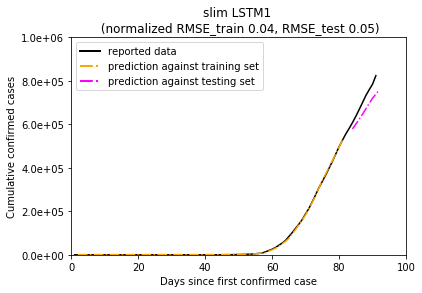

81 10
Epoch 1/50
 - 17s - loss: 0.0328
Epoch 2/50
 - 0s - loss: 0.0280
Epoch 3/50
 - 0s - loss: 0.0254
Epoch 4/50
 - 0s - loss: 0.0237
Epoch 5/50
 - 0s - loss: 0.0219
Epoch 6/50
 - 0s - loss: 0.0203
Epoch 7/50
 - 0s - loss: 0.0185
Epoch 8/50
 - 0s - loss: 0.0169
Epoch 9/50
 - 0s - loss: 0.0155
Epoch 10/50
 - 0s - loss: 0.0137
Epoch 11/50
 - 0s - loss: 0.0124
Epoch 12/50
 - 0s - loss: 0.0109
Epoch 13/50
 - 0s - loss: 0.0093
Epoch 14/50
 - 0s - loss: 0.0080
Epoch 15/50
 - 0s - loss: 0.0068
Epoch 16/50
 - 0s - loss: 0.0055
Epoch 17/50
 - 0s - loss: 0.0045
Epoch 18/50
 - 0s - loss: 0.0036
Epoch 19/50
 - 0s - loss: 0.0028
Epoch 20/50
 - 0s - loss: 0.0021
Epoch 21/50
 - 0s - loss: 0.0016
Epoch 22/50
 - 0s - loss: 0.0012
Epoch 23/50
 - 0s - loss: 8.0357e-04
Epoch 24/50
 - 0s - loss: 5.7117e-04
Epoch 25/50
 - 0s - loss: 3.7778e-04
Epoch 26/50
 - 0s - loss: 2.5079e-04
Epoch 27/50
 - 0s - loss: 1.5801e-04
Epoch 28/50
 - 0s - loss: 9.7960e-05
Epoch 29/50
 - 0s - loss: 6.2872e-05
Epoch 30/50
 - 0s

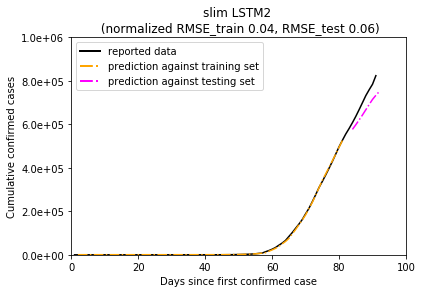

81 10
Epoch 1/50
 - 17s - loss: 0.0316
Epoch 2/50
 - 0s - loss: 0.0261
Epoch 3/50
 - 0s - loss: 0.0233
Epoch 4/50
 - 0s - loss: 0.0211
Epoch 5/50
 - 0s - loss: 0.0187
Epoch 6/50
 - 0s - loss: 0.0166
Epoch 7/50
 - 0s - loss: 0.0144
Epoch 8/50
 - 0s - loss: 0.0122
Epoch 9/50
 - 0s - loss: 0.0099
Epoch 10/50
 - 0s - loss: 0.0081
Epoch 11/50
 - 0s - loss: 0.0062
Epoch 12/50
 - 0s - loss: 0.0047
Epoch 13/50
 - 0s - loss: 0.0035
Epoch 14/50
 - 0s - loss: 0.0024
Epoch 15/50
 - 0s - loss: 0.0016
Epoch 16/50
 - 0s - loss: 9.8331e-04
Epoch 17/50
 - 0s - loss: 5.7116e-04
Epoch 18/50
 - 0s - loss: 3.2795e-04
Epoch 19/50
 - 0s - loss: 1.6851e-04
Epoch 20/50
 - 0s - loss: 9.0142e-05
Epoch 21/50
 - 0s - loss: 4.6652e-05
Epoch 22/50
 - 0s - loss: 2.6260e-05
Epoch 23/50
 - 0s - loss: 1.7400e-05
Epoch 24/50
 - 0s - loss: 1.3224e-05
Epoch 25/50
 - 0s - loss: 1.2191e-05
Epoch 26/50
 - 0s - loss: 1.1286e-05
Epoch 27/50
 - 0s - loss: 1.0667e-05
Epoch 28/50
 - 0s - loss: 1.1275e-05
Epoch 29/50
 - 0s - loss: 

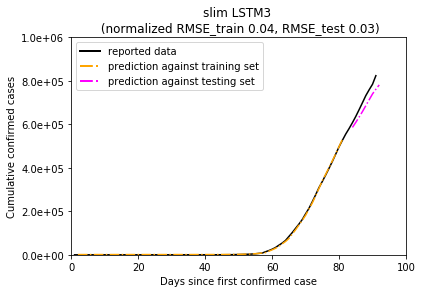

81 10
Epoch 1/50
 - 18s - loss: 0.0288
Epoch 2/50
 - 0s - loss: 0.0248
Epoch 3/50
 - 0s - loss: 0.0226
Epoch 4/50
 - 0s - loss: 0.0207
Epoch 5/50
 - 0s - loss: 0.0195
Epoch 6/50
 - 0s - loss: 0.0174
Epoch 7/50
 - 0s - loss: 0.0158
Epoch 8/50
 - 0s - loss: 0.0141
Epoch 9/50
 - 0s - loss: 0.0125
Epoch 10/50
 - 0s - loss: 0.0109
Epoch 11/50
 - 0s - loss: 0.0093
Epoch 12/50
 - 0s - loss: 0.0078
Epoch 13/50
 - 0s - loss: 0.0066
Epoch 14/50
 - 0s - loss: 0.0052
Epoch 15/50
 - 0s - loss: 0.0042
Epoch 16/50
 - 0s - loss: 0.0032
Epoch 17/50
 - 0s - loss: 0.0024
Epoch 18/50
 - 0s - loss: 0.0018
Epoch 19/50
 - 0s - loss: 0.0012
Epoch 20/50
 - 0s - loss: 8.6465e-04
Epoch 21/50
 - 0s - loss: 5.8088e-04
Epoch 22/50
 - 0s - loss: 3.5875e-04
Epoch 23/50
 - 0s - loss: 2.3103e-04
Epoch 24/50
 - 0s - loss: 1.3754e-04
Epoch 25/50
 - 0s - loss: 8.6845e-05
Epoch 26/50
 - 0s - loss: 4.7001e-05
Epoch 27/50
 - 0s - loss: 2.9360e-05
Epoch 28/50
 - 0s - loss: 1.9317e-05
Epoch 29/50
 - 0s - loss: 1.3614e-05
Epoch

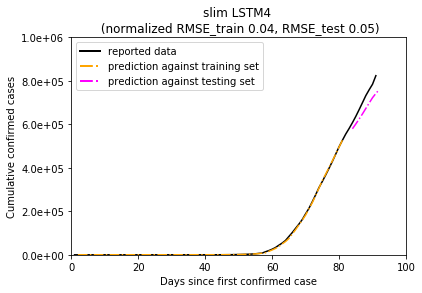

81 10
Epoch 1/50
 - 19s - loss: 0.0287
Epoch 2/50
 - 0s - loss: 0.0245
Epoch 3/50
 - 0s - loss: 0.0221
Epoch 4/50
 - 0s - loss: 0.0200
Epoch 5/50
 - 0s - loss: 0.0184
Epoch 6/50
 - 0s - loss: 0.0161
Epoch 7/50
 - 0s - loss: 0.0141
Epoch 8/50
 - 0s - loss: 0.0120
Epoch 9/50
 - 0s - loss: 0.0100
Epoch 10/50
 - 0s - loss: 0.0081
Epoch 11/50
 - 0s - loss: 0.0062
Epoch 12/50
 - 0s - loss: 0.0046
Epoch 13/50
 - 0s - loss: 0.0033
Epoch 14/50
 - 0s - loss: 0.0022
Epoch 15/50
 - 0s - loss: 0.0014
Epoch 16/50
 - 0s - loss: 7.8509e-04
Epoch 17/50
 - 0s - loss: 4.3132e-04
Epoch 18/50
 - 0s - loss: 2.2490e-04
Epoch 19/50
 - 0s - loss: 1.0242e-04
Epoch 20/50
 - 1s - loss: 5.2385e-05
Epoch 21/50
 - 0s - loss: 2.7000e-05
Epoch 22/50
 - 0s - loss: 1.5717e-05
Epoch 23/50
 - 0s - loss: 1.1568e-05
Epoch 24/50
 - 0s - loss: 9.7780e-06
Epoch 25/50
 - 0s - loss: 9.7065e-06
Epoch 26/50
 - 0s - loss: 9.2958e-06
Epoch 27/50
 - 1s - loss: 9.7899e-06
Epoch 28/50
 - 0s - loss: 9.4689e-06
Epoch 29/50
 - 0s - loss: 

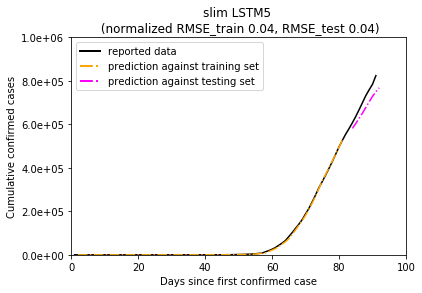

81 10
Epoch 1/50
 - 17s - loss: 0.0385
Epoch 2/50
 - 0s - loss: 0.0270
Epoch 3/50
 - 0s - loss: 0.0191
Epoch 4/50
 - 0s - loss: 0.0137
Epoch 5/50
 - 0s - loss: 0.0089
Epoch 6/50
 - 0s - loss: 0.0058
Epoch 7/50
 - 0s - loss: 0.0033
Epoch 8/50
 - 0s - loss: 0.0018
Epoch 9/50
 - 0s - loss: 8.6515e-04
Epoch 10/50
 - 0s - loss: 4.2463e-04
Epoch 11/50
 - 0s - loss: 1.8253e-04
Epoch 12/50
 - 0s - loss: 8.6157e-05
Epoch 13/50
 - 0s - loss: 4.4392e-05
Epoch 14/50
 - 0s - loss: 2.5650e-05
Epoch 15/50
 - 0s - loss: 2.0112e-05
Epoch 16/50
 - 0s - loss: 1.8912e-05
Epoch 17/50
 - 0s - loss: 1.7804e-05
Epoch 18/50
 - 0s - loss: 1.8618e-05
Epoch 19/50
 - 0s - loss: 1.8969e-05
Epoch 20/50
 - 0s - loss: 1.7785e-05
Epoch 21/50
 - 0s - loss: 1.8760e-05
Epoch 22/50
 - 0s - loss: 1.9208e-05
Epoch 23/50
 - 0s - loss: 1.8890e-05
Epoch 24/50
 - 0s - loss: 1.9190e-05
Epoch 25/50
 - 0s - loss: 2.2015e-05
Epoch 26/50
 - 0s - loss: 1.8859e-05
Epoch 27/50
 - 0s - loss: 1.7955e-05
Epoch 28/50
 - 0s - loss: 1.9623e-0

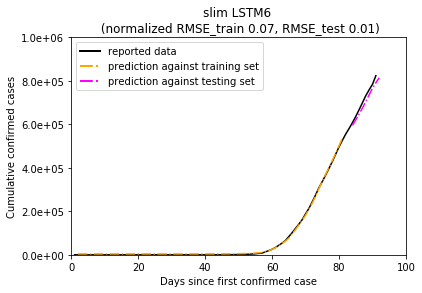

81 10
Epoch 1/50
 - 18s - loss: 0.0133
Epoch 2/50
 - 0s - loss: 0.0102
Epoch 3/50
 - 0s - loss: 0.0078
Epoch 4/50
 - 0s - loss: 0.0062
Epoch 5/50
 - 0s - loss: 0.0046
Epoch 6/50
 - 0s - loss: 0.0033
Epoch 7/50
 - 0s - loss: 0.0022
Epoch 8/50
 - 0s - loss: 0.0015
Epoch 9/50
 - 0s - loss: 8.8909e-04
Epoch 10/50
 - 0s - loss: 4.5555e-04
Epoch 11/50
 - 0s - loss: 2.4183e-04
Epoch 12/50
 - 0s - loss: 1.2642e-04
Epoch 13/50
 - 0s - loss: 6.0306e-05
Epoch 14/50
 - 0s - loss: 3.0435e-05
Epoch 15/50
 - 0s - loss: 1.7916e-05
Epoch 16/50
 - 0s - loss: 1.3371e-05
Epoch 17/50
 - 0s - loss: 1.1469e-05
Epoch 18/50
 - 0s - loss: 1.1235e-05
Epoch 19/50
 - 0s - loss: 1.0810e-05
Epoch 20/50
 - 0s - loss: 1.0515e-05
Epoch 21/50
 - 0s - loss: 1.0438e-05
Epoch 22/50
 - 0s - loss: 1.0603e-05
Epoch 23/50
 - 0s - loss: 1.0895e-05
Epoch 24/50
 - 0s - loss: 1.0116e-05
Epoch 25/50
 - 0s - loss: 1.0896e-05
Epoch 26/50
 - 0s - loss: 1.0366e-05
Epoch 27/50
 - 0s - loss: 1.1504e-05
Epoch 28/50
 - 0s - loss: 1.1585e-0

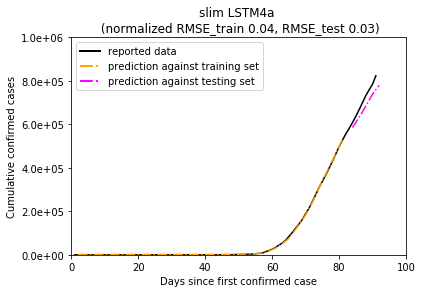

81 10
Epoch 1/50
 - 18s - loss: 0.0132
Epoch 2/50
 - 0s - loss: 0.0099
Epoch 3/50
 - 0s - loss: 0.0075
Epoch 4/50
 - 0s - loss: 0.0057
Epoch 5/50
 - 0s - loss: 0.0041
Epoch 6/50
 - 0s - loss: 0.0027
Epoch 7/50
 - 0s - loss: 0.0017
Epoch 8/50
 - 0s - loss: 0.0010
Epoch 9/50
 - 0s - loss: 5.5054e-04
Epoch 10/50
 - 0s - loss: 2.3803e-04
Epoch 11/50
 - 0s - loss: 1.0796e-04
Epoch 12/50
 - 0s - loss: 5.0257e-05
Epoch 13/50
 - 0s - loss: 2.3442e-05
Epoch 14/50
 - 0s - loss: 1.4296e-05
Epoch 15/50
 - 0s - loss: 1.1411e-05
Epoch 16/50
 - 0s - loss: 1.1171e-05
Epoch 17/50
 - 0s - loss: 1.0655e-05
Epoch 18/50
 - 0s - loss: 1.1001e-05
Epoch 19/50
 - 0s - loss: 1.0808e-05
Epoch 20/50
 - 0s - loss: 1.0537e-05
Epoch 21/50
 - 0s - loss: 1.0441e-05
Epoch 22/50
 - 0s - loss: 1.0637e-05
Epoch 23/50
 - 0s - loss: 1.0912e-05
Epoch 24/50
 - 0s - loss: 1.0111e-05
Epoch 25/50
 - 0s - loss: 1.0951e-05
Epoch 26/50
 - 0s - loss: 1.0361e-05
Epoch 27/50
 - 0s - loss: 1.1591e-05
Epoch 28/50
 - 0s - loss: 1.1785e-0

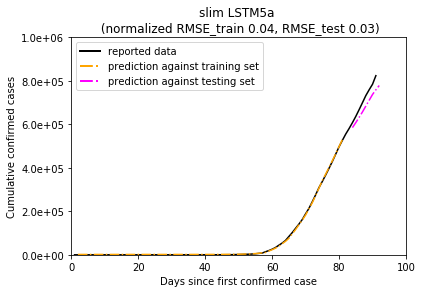

81 10
Epoch 1/50
 - 19s - loss: 0.0334
Epoch 2/50
 - 0s - loss: 0.0288
Epoch 3/50
 - 0s - loss: 0.0267
Epoch 4/50
 - 0s - loss: 0.0254
Epoch 5/50
 - 0s - loss: 0.0239
Epoch 6/50
 - 0s - loss: 0.0225
Epoch 7/50
 - 0s - loss: 0.0211
Epoch 8/50
 - 0s - loss: 0.0196
Epoch 9/50
 - 0s - loss: 0.0178
Epoch 10/50
 - 0s - loss: 0.0161
Epoch 11/50
 - 0s - loss: 0.0142
Epoch 12/50
 - 0s - loss: 0.0123
Epoch 13/50
 - 0s - loss: 0.0105
Epoch 14/50
 - 0s - loss: 0.0089
Epoch 15/50
 - 0s - loss: 0.0073
Epoch 16/50
 - 0s - loss: 0.0059
Epoch 17/50
 - 0s - loss: 0.0047
Epoch 18/50
 - 0s - loss: 0.0036
Epoch 19/50
 - 0s - loss: 0.0027
Epoch 20/50
 - 0s - loss: 0.0020
Epoch 21/50
 - 0s - loss: 0.0014
Epoch 22/50
 - 0s - loss: 9.7538e-04
Epoch 23/50
 - 0s - loss: 6.7453e-04
Epoch 24/50
 - 0s - loss: 4.2716e-04
Epoch 25/50
 - 0s - loss: 2.7528e-04
Epoch 26/50
 - 0s - loss: 1.7149e-04
Epoch 27/50
 - 0s - loss: 1.0347e-04
Epoch 28/50
 - 0s - loss: 5.9667e-05
Epoch 29/50
 - 0s - loss: 3.8703e-05
Epoch 30/50
 

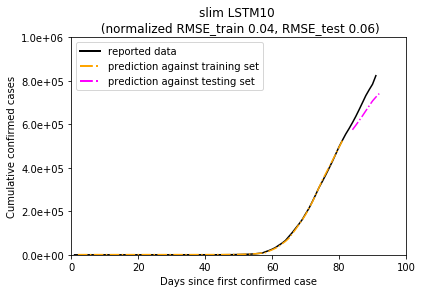

81 10
Epoch 1/50
 - 19s - loss: 0.0333
Epoch 2/50
 - 0s - loss: 0.0286
Epoch 3/50
 - 0s - loss: 0.0265
Epoch 4/50
 - 0s - loss: 0.0252
Epoch 5/50
 - 0s - loss: 0.0236
Epoch 6/50
 - 0s - loss: 0.0221
Epoch 7/50
 - 0s - loss: 0.0205
Epoch 8/50
 - 0s - loss: 0.0187
Epoch 9/50
 - 0s - loss: 0.0165
Epoch 10/50
 - 0s - loss: 0.0142
Epoch 11/50
 - 0s - loss: 0.0117
Epoch 12/50
 - 0s - loss: 0.0091
Epoch 13/50
 - 0s - loss: 0.0068
Epoch 14/50
 - 0s - loss: 0.0048
Epoch 15/50
 - 0s - loss: 0.0031
Epoch 16/50
 - 0s - loss: 0.0019
Epoch 17/50
 - 0s - loss: 0.0011
Epoch 18/50
 - 0s - loss: 5.4580e-04
Epoch 19/50
 - 0s - loss: 2.6177e-04
Epoch 20/50
 - 0s - loss: 1.1358e-04
Epoch 21/50
 - 0s - loss: 4.9092e-05
Epoch 22/50
 - 0s - loss: 2.3123e-05
Epoch 23/50
 - 0s - loss: 1.3180e-05
Epoch 24/50
 - 0s - loss: 9.5244e-06
Epoch 25/50
 - 0s - loss: 8.6359e-06
Epoch 26/50
 - 0s - loss: 8.3724e-06
Epoch 27/50
 - 0s - loss: 8.3390e-06
Epoch 28/50
 - 0s - loss: 8.2521e-06
Epoch 29/50
 - 0s - loss: 8.3067e-

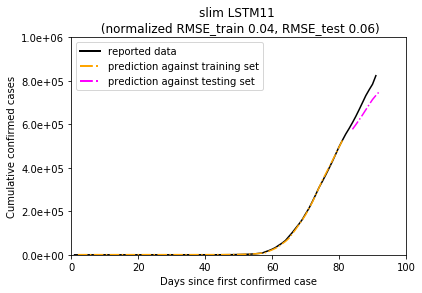

In [154]:
#Slim LSTM training

Data = np.array(usa_cum).reshape((len(usa_cum),1))

def create_dataset(data, look_back=1):
    f = len(data)-look_back
    return data[:f],data[1:f+1]

#acts = ['tanh'] #'sigmoid' ,'tanh'
#include all your models ina list
lstms = ['LSTM1', 'LSTM2', 'LSTM3', 'LSTM4', 'LSTM5', 'LSTM6', 'LSTM4a', 'LSTM5a', 'LSTM10', 'LSTM11']
#inlcude all your lr (grid) in a list
#Use the name label of the model for the file
names = ['lstm1', 'lstm2', 'lstm3', 'lstm4', 'lstm5', 'lstm6', 'lstm4a', 'lstm5a', 'lstm10', 'lstm11']

with open('infos.txt','w') as file:
    file.write('RMSE_train normalized_RMSE_train RMSE_test normalized_RMSE_test \n')
    file.close()
    
for cnt, lstm in enumerate(lstms):
    origData = np.copy(Data)
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(origData) # normalize data

    train_size = int(len(dataset) * 0.90)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    print(len(train), len(test))
    # print(f'train\n{train}')
    # print(f'test\n{test.shape}')

    look_back = 1
    X_train, y_train = create_dataset(train, look_back)
    X_test, y_test = create_dataset(test, look_back)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

    np.random.seed(3)
    model = Sequential()           
    lstmi = LSTMs(implementation= 1, units=10,
            activation='tanh',
            input_shape=X_train.shape[1:], model=lstm)
    model.add(lstmi)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=2) 

    # make predictions
    trainPredict = model.predict(X_train)
    testPredict = model.predict(X_test)
    trainPredict = scaler.inverse_transform(trainPredict)
    y_train = scaler.inverse_transform(y_train)
    testPredict = scaler.inverse_transform(testPredict)
    y_test = scaler.inverse_transform(y_test)
    
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(y_train[:,0], trainPredict[:,0]))
    print(len(y_train[:,0]))
    print(len(trainPredict[:,0]))
    print('train score: %.2f RMSE' % (trainScore))
    print('normalized train score: %.2f RMSE/mean' % (trainScore/np.mean(y_train[:,0])))
    testScore = math.sqrt(mean_squared_error(y_test[:,0], testPredict[:,0]))
    print('test score: %.2f RMSE' % (testScore))
    print('normalized test score: %.2f RMSE/mean' % (testScore/np.mean(y_test[:,0])))
    
    with open('infos.txt','a') as file:
        file.write('{} {} {} {} \n'.format(trainScore,trainScore/np.mean(y_train[:,0]),testScore,testScore/np.mean(y_test[:,0])))
        file.close()

    # plot baseline and predictions from the correct start point
    days_Data = np.arange(1, len(Data)+1,1)
    days_trainPred = np.arange(2, len(trainPredict)+2,1)
    days_testPred = np.arange(2, len(testPredict)+2,1)+len(trainPredict)+1+1

    fig, ax = plt.subplots()
    ax.plot(days_Data,Data, color='k')
    ax.plot(days_trainPred,trainPredict, color='orange',linestyle = '-.')
    ax.plot(days_testPred,testPredict, color='magenta',linestyle = '-.')

    ax.set_xlabel('Days since first confirmed case')
    ax.set_ylabel('Cumulative confirmed cases')
    ax.set_xlim(0,100)
    ax.set_ylim(0,1e6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
    ax.set_title('slim %s \n (normalized RMSE_train %.2f, RMSE_test %.2f)' % (lstm,trainScore/np.mean(y_train[:,0]),testScore/np.mean(y_test[:,0])))

    legend_elements = [Line2D([0], [0], color='k', lw=2, label='reported data'),
                       Line2D([0], [0], color='orange', linestyle = '-.', lw=2,label='prediction against training set'),
                       Line2D([0], [0], color='magenta', linestyle = '-.', lw=2, label='prediction against testing set')]

    ax.legend(handles=legend_elements, loc='best')
    fig.savefig("slim_{}.pdf".format(lstm), bbox_inches='tight')
    plt.show()
